In [2]:
from func_SCA_mapping import *

/Users/yangkehan/projects/personal/High_resolution_snow_cover_mapping/func_SCA_mapping.py:30: ClientV1DeprecationWarning: The planet.api module is deprecated and will be removed in version 2.0.0. For more details please see the discussion at https://github.com/planetlabs/planet-client-python/discussions.
  from planet.api.auth import find_api_key


In [5]:
flag_rasterize = False

dir_ROI = "./data/ROI/20180528_181110_add_UTM11.shp"
dir_raster = "./data/planet/train/20180528_181110_1025_3B_AnalyticMS_SR_clip.tif"
dir_ROIraster = './data/ROI/ROI_20180528_181110_add.tif'
dir_samples_root = './data/samples/sample_'
dir_samples = './data/samples/sample_174k.csv'

if flag_rasterize:
    flag_output = True
    # rasterize ROI
    ROI = vector_rasterize(dir_vector=dir_ROI, dir_raster=dir_raster, dir_out=dir_ROIraster, flag_output = flag_output)
    
    # save surface reflectance and lable to csv file
    N_scale = 10000.0
    img = rasterio.open(dir_raster)
    ROI = rasterio.open(dir_ROIraster)
    img_read = img.read()/N_scale
    df_img = pd.DataFrame(img_read.reshape([4,-1]).T)
    df_label = pd.DataFrame(ROI.read().reshape([1,-1]).T)

    df_train = pd.concat([df_img, df_label], axis = 1)
    df_train.columns = ['blue','green','red','nir','label']
    df_train['ndvi'] = (df_train['nir']-df_train['red'])/(df_train['nir']+df_train['red'])
    df_train = df_train[df_train.label !=9]
    df_train.label = np.where(df_train.label > 0, 1, 0)
    dir_samples = dir_samples_root + str(int(len(df_train.index)/1000)) + 'k.csv'
    df_train.to_csv(dir_samples, index = False)
else:
    df_train = pd.read_csv(dir_samples)

Repeat times: 10000
F1-score: 0.99902 (0.00025)
Balanced Accuracy: 0.99908 (0.00024)
Accuracy: 0.99915 (0.00021)
Total time used: 158.4


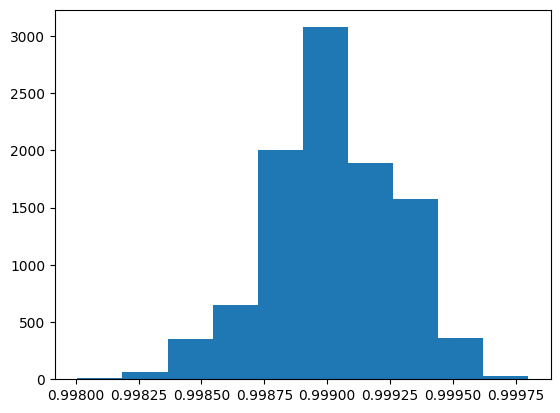

In [7]:
flag_train = False

# get data 
dir_model = "./data/models/random_forest_20240116_binary_174K.joblib"
dir_score = './data/models/random_forest_20240116_binary_174K_scores.csv'
starttime = time.process_time()
if True:
    X = df_train[['blue', 'green','red','nir']]
    y = df_train['label']
    
    # pre-process ndvi value to -1.0 to 1.0; fill nan to finite value 
    # X[X['ndvi']< -1.0]['ndvi'] = -1.0
    # X[X['ndvi']> 1.0]['ndvi'] = 1.0
    # X[np.isfinite(X['ndvi']) == False]['ndvi'] = np.nan

    # define the model
    model = RandomForestClassifier(n_estimators=10, max_depth=10, max_features=4, random_state=1)#
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1000, random_state=1)
    n_accuracy = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    n_f1 = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
    n_balanced_accuracy = cross_val_score(model, X, y, scoring='balanced_accuracy', cv=cv, n_jobs=-1, error_score='raise')
    
    # report performance
    plt.hist(n_f1)
    print('Repeat times:'.format(), len(n_f1))
    print('F1-score: %.5f (%.5f)' % (n_f1.mean(), n_f1.std()))
    print('Balanced Accuracy: %.5f (%.5f)' % (n_balanced_accuracy.mean(), n_balanced_accuracy.std()))
    print('Accuracy: %.5f (%.5f)' % (n_accuracy.mean(), n_accuracy.std()))

    # fit model with all observations
    model.fit(X,y)
    # save model 
    joblib.dump(model, dir_model)
    # save accuracy 
    scores = pd.DataFrame()
    scores["accuracy"] = n_accuracy
    scores['f1'] = n_f1
    scores['balanced_accuracy'] = n_balanced_accuracy
    scores.to_csv(dir_score, index = False)

    print('Total time used:'.format(), round(time.process_time() - starttime, 1))